In [2]:
#import modules
import numpy as np
import csv
import scipy.optimize
import matplotlib.pyplot as plt

In [3]:
#helper function [Literal parth hizo una funcion para leer mas facil]
def readFile(fileName):
    with open(fileName) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)
    return d


In [4]:
#Likelihood function for body-Tail [It was not possible to get an analytical solution] [We still need to maximize it]
def tail_body_likelihood(start,r, pen):
    #l is lambda for the exponential distribution
    
    l = start[0]
    alpha = start[1]
    rmin = start[2]
    
    C = 2 - np.exp(-l*rmin) # Normalization constant
    L = 0 # Initializing likelihood
    
    #finding returns lower than rmin
    r = np.sort(r, axis = 0)
    count = 0
    for i in r:
        if(i < rmin):
            count = count+1
    f = count
    
    #Computing log-likelihood values for the body of the distribution
    for j in range(1,f):
        L = L - np.log(C) + np.log(l) -l*r[j]
        
    #Computing log-likelihood values for the tail of the distribution
    for k in range(f+1,len(r)):
        L = L - np.log(C) + np.log(alpha/rmin) - (alpha+1)*np.log(r[k]/rmin)
    # Computing values of body and tail distributions at rmin
    
    Fbody = l*np.exp(-l*rmin)/C
    Ftail = alpha/(C*rmin) #We didnt include the other part of the power law formula because it is (rmin/rmin)=1
    
    # Adding penalty term to enforce continuity
    L = L - pen*(Fbody-Ftail)**2
    
    # The function fmin calculates the minimum of a function, we want the maximum, therefore we invert our value.
    L = -L
    return L


In [5]:
file = readFile("DS.txt")
data = file
b = data[0]

r = np.zeros((len(b)-1,1))
count = 0
#Computing log returns and only selecting nehative or positive returns
for i in range(len(b)-1):
    den = float(b[i])
    num = float(b[i+1])
    ret = np.log(num/den)
    #if ret > 0: #Only selecting positive returns
    if ret < 0:  #Only selecting negative returns
        r[i]= ret
        count = count+1

r = np.absolute(r[r != 0])     #For convenience we make negative returns positive and take away the zeros 

#We need penalty term to enforce continuity between body and tail
penalty = 10 #We have to try different penalty values, we know 10 works

lambd = 10
alpha = 2
rmin = 0.05

start = [lambd, alpha, rmin]

# Choose lambda, alpha and rmin to Maximize likelihood function
params = scipy.optimize.fmin(tail_body_likelihood,x0=start, args=(r,penalty,),maxiter=1000,maxfun=5000,xtol=1e-12)
#print(tail_body_likelihood(start,r, penalty)) Para probar funcion con ciertos parametros


<ipython-input-4-f701dd0f9267>:26: RuntimeWarning: invalid value encountered in log
  L = L - np.log(C) + np.log(alpha/rmin) - (alpha+1)*np.log(r[k]/rmin)


Optimization terminated successfully.
         Current function value: -942.410247
         Iterations: 299
         Function evaluations: 589


In [6]:
#Maximum likelihood parameters
lam = params[0]
alpha = params[1]
rmin = params[2]

print('Parameters that maximize likelihood:')
print('Lambda = ',lam)
print('Alpha = ',alpha)
print('rmin = ',rmin)

# Normalization constant
C = 2 - np.exp(-lam*rmin)

Parameters that maximize likelihood:
Lambda =  118.0050754294858
Alpha =  0.37095848927908515
rmin =  0.008452594754230838


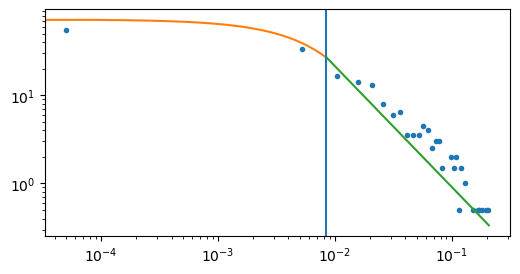

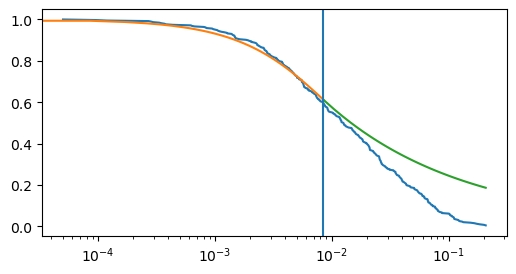

In [12]:
NB = 40
h,xr = np.histogram(r,NB, density = True);

# Exponential distribution
x = np.linspace(0,rmin,100)
f = lam*np.exp(-lam*x)/C

# Power law distribution
x2 = np.linspace(rmin,max(r),100)
f2 = alpha*(x2/rmin)**(-alpha-1)/(C*rmin)

plot1 = plt.figure(1,figsize=(6,3), dpi=100)
plt.plot(xr[:-1],h,".")
plt.plot(x,f)
plt.plot(x2,f2)
plt.axvline(rmin) #vertical line where exponential and powerl law distributions meet
plt.yscale('log')
plt.xscale('log')

# Inv CDF
r = np.sort(r,axis=0)
y = np.arange(0,len(r),1)
y = 1-y/(len(r)+1) #Es como el profe hizo el CDF que no entendiste taan bien checa matlab
f3 = 1-(1-np.exp(-lam*x))/C
f4 = 1-(1-np.exp(-lam*rmin)+1-(rmin/x2)**alpha)/C

plot2 = plt.figure(2,figsize=(6,3), dpi=100)
plt.plot(r,y)
plt.plot(x,f3)
plt.plot(x2,f4)
plt.axvline(rmin)
plt.xscale('log')
